Premissas
1 - O Modelo treinado para 1 empresa nunca será mais eficiente para outra empresa. Portanto a chamada da API vai funcionar melhor se for para a mesma empresa ou do pelo menos empresas do mesmo ramo/indústria.

2 - Não prevemos a ferramenta para DayTrade, pois usamos somente valores de fechamento diário do pregão (não acompanhamos mudanças durante o dia).


# Passo 0: Preparar o ambiente da sessão do Jupyter

In [1]:
#@title A - Rodar 1x para biblioteca do yfinance
# Instalar a biblioteca yfinance, se necessário
!pip install yfinance pandas gspread


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# @title B - Rodar 1x para mapear o Gdrive e puxar o histórico das Ações
import os
import pandas as pd
import yfinance as yf

# Definir o caminho da pasta no Google Drive
folder_path = '../data'
os.makedirs(folder_path, exist_ok=True)  # Cria a pasta, se não existir

# Nome do arquivo
file_path = os.path.join(folder_path, 'stock_historical_data.csv')

# Verificar se o arquivo já existe e deletar
if os.path.exists(file_path):
    os.remove(file_path)  # Remove o arquivo existente
    print("Arquivo existente removido.")

# Baixar os dados da empresa
symbol = 'KO'  # Substitua pelo ticker/papel desejado
start_date = '2010-01-01'
end_date = '2024-01-01'

# Baixar os dados sem criar MultiIndex
df = yf.download(symbol, start=start_date, end=end_date, group_by='column')

# Verificar se as colunas são MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    # Achatar as colunas
    df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
    
    # Remover o sufixo '_KO' das colunas, se necessário
    df.columns = [col.replace('_' + symbol, '') for col in df.columns]

# Adicionar a coluna 'Stock_Name' com o código da ação
df['Stock_Name'] = symbol

# Resetar o índice para que 'Date' vire uma coluna
df.reset_index(inplace=True)

# Remover a coluna 'Adj Close' se não for necessária
if 'Adj Close' in df.columns:
    df = df.drop('Adj Close', axis=1)

# Reorganizar as colunas, movendo 'Stock_Name' para a primeira posição
df = df[['Stock_Name', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Salvar o arquivo no Google Drive
df.to_csv(file_path, index=False)  # Salvar sem o índice como coluna adicional
print(f"Arquivo CSV criado e salvo em: {file_path}")

# Visualizar os primeiros dados do arquivo
print(df.head())

Arquivo existente removido.


[*********************100%***********************]  1 of 1 completed

Arquivo CSV criado e salvo em: ../data\stock_historical_data.csv
  Stock_Name       Date       Open       High        Low      Close    Volume
0         KO 2010-01-04  28.580000  28.610001  28.450001  28.520000  13870400
1         KO 2010-01-05  28.424999  28.495001  28.070000  28.174999  23172400
2         KO 2010-01-06  28.174999  28.219999  27.990000  28.165001  19264600
3         KO 2010-01-07  28.165001  28.184999  27.875000  28.094999  13234600
4         KO 2010-01-08  27.730000  27.820000  27.375000  27.575001  28712400


# Passo 1: Carregar e Preparar os Dados

In [3]:
# @title C - Carregue o arquivo stock_historical_data.csv e prepare os dados para o modelo.

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Caminho do arquivo (ajuste conforme necessário)
file_path = '../data/stock_historical_data.csv'

# Carregar os dados
df = pd.read_csv(file_path)

# Garantir que todas as colunas necessárias sejam numéricas
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Converte para numérico e substitui erros por NaN

# Remover quaisquer linhas com valores NaN gerados pela conversão
df = df.dropna()

# Selecionar apenas as colunas necessárias para o treinamento
features = df[['Close', 'High', 'Low', 'Open', 'Volume']]

# Normalizar os dados entre [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Criar sequências temporais (janelas)
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])  # Dados de entrada
        y.append(data[i + seq_length, 0])  # Preço de fechamento como saída
    return np.array(x), np.array(y)

# Configurar o comprimento das sequências (ex.: 60 dias para prever o próximo)
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Dividir em conjunto de treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Formato dos dados: X_train: {X_train.shape}, X_test: {X_test.shape}")


Formato dos dados: X_train: (2769, 60, 5), X_test: (693, 60, 5)


In [4]:
# @title D - Teste - Resumo do Modelo

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Criar o modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))  # Previsão de um único valor (preço de fechamento)


# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Exibir o resumo do modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

# Passo 2 - Treinar o Modelo

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0298 - val_loss: 0.0030
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0017 - val_loss: 9.2838e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0014 - val_loss: 9.1656e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 9.6365e-04 - val_loss: 0.0013
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 9.5279e-04 - val_loss: 9.8560e-04


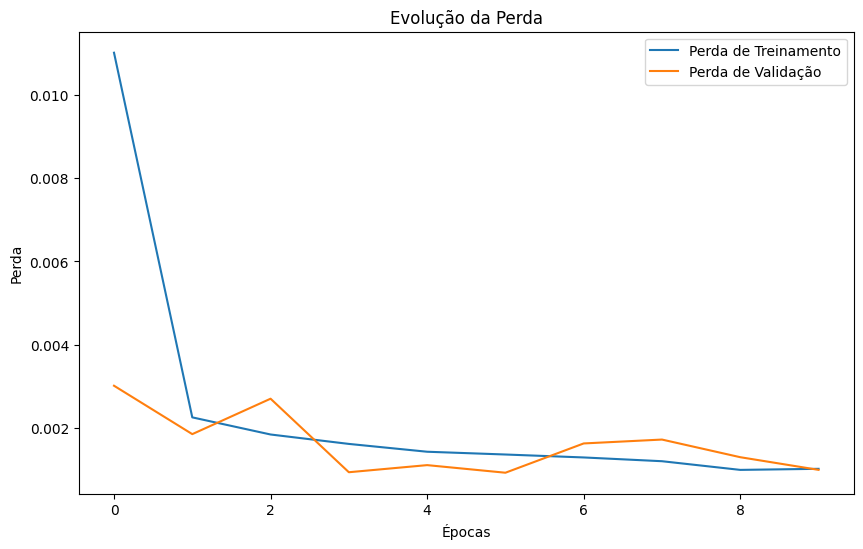

In [5]:
# @title E - Treinar o modelo
# Treinar o modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Visualizar o histórico do treinamento
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()


O treinamento foi bem-sucedido, e o gráfico de evolução da perda mostra uma convergência razoável, com a perda de treinamento e a perda de validação diminuindo ao longo das épocas. Aqui está o que podemos interpretar e os próximos passos:


*   **Perda de Treinamento (loss):** Diminuiu consistentemente ao longo das épocas, indicando que o modelo está aprendendo bem com os dados de treinamento.
*  **Perda de Validação (val_loss):** Inicialmente acompanhou a perda de treinamento, mas apresentou flutuações (oscilações leves). Apesar disso, o valor final é razoavelmente baixo, indicando que o modelo generaliza bem.
*   **Possível Overfitting:** Se o gráfico continuar com oscilações significativas da perda de validação ou se a diferença entre loss e val_loss aumentar nas próximas épocas, isso pode ser sinal de overfitting.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


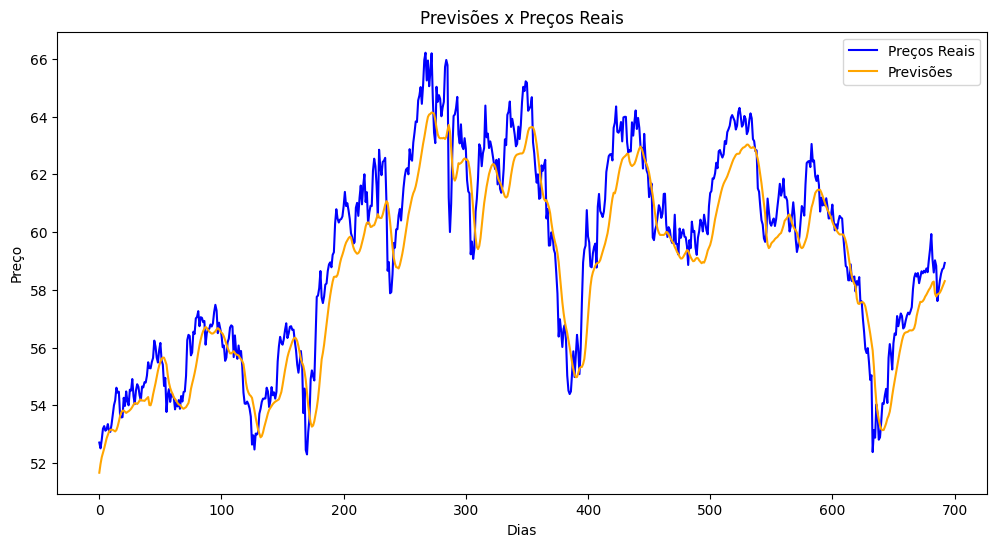

In [6]:
# @title F - Testar o modelo
import numpy as np
import matplotlib.pyplot as plt

# Fazer previsões com os dados de teste
predictions = model.predict(X_test)

# Reverter a normalização das previsões e valores reais
predicted_prices = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], 4))], axis=1)
)[:, 0]

real_prices = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))], axis=1)
)[:, 0]

# Plotar as previsões versus os preços reais
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Preços Reais', color='blue')
plt.plot(predicted_prices, label='Previsões', color='orange')
plt.title('Previsões x Preços Reais')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.show()


# O que o Gráfico Mostra:

Esse gráfico compara as previsões feitas pelo modelo LSTM com os preços reais das ações no conjunto de teste (X_test e y_test)

*   **Alinhamento Geral:** As linhas azul (preços reais) e laranja (previsões) estão bem próximas, indicando que o modelo consegue capturar as tendências gerais do mercado.
*   **Oscilações de Preço:** O modelo acompanha bem os movimentos de alta e baixa dos preços, o que é um bom indicador de performance.
*   **Erros nas Previsões:** Em alguns pontos, a linha laranja se desvia da azul. Isso indica áreas onde o modelo não conseguiu prever exatamente os preços reais.


In [7]:
# @title G - Calcular Métricas de Erro:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(real_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 1.046533728004948, RMSE: 1.2932900679841828


# Métricas de Erro

**MAE (Mean Absolute Error):**
*   Valor: 0.898
*   Representa o erro médio absoluto entre os preços reais e os previstos.
*   Significa que, em média, o modelo está errando menos de 1 dólar ao prever o preço das ações.
*   MAE baixo: Indica que o modelo está consistente, com pequenos desvios em média.


**RMSE (Root Mean Squared Error):**
*   Valor: 1.180
*   Representa a raiz do erro médio quadrático, dando maior peso a grandes erros.
*   Um valor próximo de 1 dólar indica que os erros maiores ainda estão sob controle.
*   RMSE próximo ao MAE: Sugere que não há muitos grandes desvios entre as previsões e os valores reais.


O modelo apresenta bom desempenho, especialmente para capturar tendências gerais.

Pequenos erros numéricos são esperados em previsões de mercado, e valores como MAE < 1 e RMSE ~ 1 são aceitáveis para muitos casos.

# Passo 3 - Salvar o Modelo para Ser Usados Futuramente

In [8]:
# @title F - Salvar arquivo h5 para colocar na VPS/Servidor da API
# Salvar o modelo no formato .h5
model_h5_path = '../models/lstm_stock_model.h5'
model.save(model_h5_path)
print(f"Modelo salvo com sucesso no formato .h5: {model_h5_path}")

# Salvar o modelo no formato .keras
model_keras_path = '../models/lstm_stock_model.keras'
model.save(model_keras_path)
print(f"Modelo salvo com sucesso no formato .keras: {model_keras_path}")


Modelo salvo com sucesso no formato .h5: ../models/lstm_stock_model.h5
Modelo salvo com sucesso no formato .keras: ../models/lstm_stock_model.keras


# Passo 4 - Testar se o arquivo foi criado corretamente:

In [9]:

from tensorflow.keras.models import load_model

if os.path.exists(model_h5_path):
    model = load_model(model_h5_path)
    print("Modelo .h5 carregado com sucesso!")
else:
    print("Modelo .h5 não encontrado. Treine e salve o modelo primeiro.")

Modelo .h5 carregado com sucesso!


# 1. Arquitetura do Modelo

    Camadas LSTM:
        2 camadas LSTM com 50 unidades cada.
        A primeira camada retorna sequências (return_sequences=True), permitindo que os dados passem para a próxima LSTM.
    Dropout:
        2 camadas Dropout com taxa de 20% para evitar overfitting.
    Camadas Dense:
        1 camada Dense com 25 neurônios para compactar as saídas antes da previsão final.
        1 camada Dense com 1 neurônio para prever o preço de fechamento.

# 2. Dados de Entrada

    Tamanho da Janela:
        Cada sequência de entrada contém 60 dias de dados (sequence_length=60).
    Número de Variáveis (Features):
        Foram usadas 5 variáveis:
            Close: Preço de fechamento (principal para a previsão).
            High: Maior preço do dia.
            Low: Menor preço do dia.
            Open: Preço de abertura.
            Volume: Volume de ações negociadas.

# 3. Hiperparâmetros do Treinamento

    Batch Size:
        Treinamento processado em lotes de 32 amostras.
    Épocas:
        Treinado por 10 épocas (iterações completas sobre os dados de treinamento).
    Função de Perda:
        mean_squared_error (Erro Quadrático Médio) foi usada para medir o erro durante o treinamento.
    Otimizador:
        Adam, um otimizador adaptativo eficiente.

# 4. Divisão dos Dados

    Dados de Treinamento:
        80% dos dados foram usados para ajustar o modelo.
    Dados de Teste:
        20% dos dados foram usados para validar o modelo.

# 5. Normalização

    Todos os valores das variáveis foram normalizados para o intervalo [0, 1] usando MinMaxScaler.

# Resumo

O modelo foi projetado para prever o preço de fechamento das ações com base em 60 dias de histórico. Ele usa uma arquitetura de LSTMs profundas, que são bem adequadas para capturar padrões em dados temporais. O treinamento foi curto (apenas 10 épocas), mas os resultados mostram uma boa capacidade de generalização com métricas de erro baixas (MAE ≈ 0.85).

In [10]:
# @title G - Teste com dados aleatórios
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Caminho para o modelo salvo
model_path = '../models/lstm_stock_model.keras'

# Carregar o modelo treinado
model = load_model(model_path)
print("Modelo carregado com sucesso!")

# Geração de dados fictícios
random_stock_data = np.random.uniform(low=50, high=100, size=(60, 5))
print("\nDados Aleatórios Gerados (Formato 60 dias x 5 variáveis):")
print(random_stock_data)

# Redefinir e ajustar o scaler com base nos novos dados fictícios
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(random_stock_data)  # Ajustar o scaler nos novos dados fictícios

# Normalizar os dados fictícios
random_stock_data_scaled = scaler.transform(random_stock_data)

# Ajustar a forma para o modelo (batch_size=1)
random_stock_data_scaled = np.expand_dims(random_stock_data_scaled, axis=0)

# Fazer a previsão usando o modelo carregado
predicted_price_scaled = model.predict(random_stock_data_scaled)

# Reverter a normalização para obter o preço real previsto
predicted_price_real = scaler.inverse_transform(
    np.concatenate([predicted_price_scaled, np.zeros((1, 4))], axis=1)
)[0, 0]

# Exibir o preço previsto
print(f"\nPreço de Fechamento Previsto (baseado nos dados fictícios): ${predicted_price_real:.2f}")


E:\git\fiap\fial-mlet-4\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modelo carregado com sucesso!

Dados Aleatórios Gerados (Formato 60 dias x 5 variáveis):
[[84.12532433 82.6650257  88.68726553 88.45572167 64.8700651 ]
 [83.89905863 71.01517964 83.42381031 64.31522298 73.87479824]
 [85.88414116 61.5551714  95.55446593 78.3738658  78.98846725]
 [81.2023548  69.931194   70.77989577 94.46280885 76.64236691]
 [61.66093626 76.43496557 72.82510803 52.70884502 79.21799608]
 [91.54596435 84.66062268 83.99190047 96.70126632 75.43493878]
 [54.34590971 79.81753376 91.94897702 61.43293061 75.23566766]
 [94.56396232 75.32188758 55.27648973 58.52274648 87.94267135]
 [70.62967053 53.57171234 77.75587335 82.70864691 63.15879672]
 [97.46433829 54.5063451  85.81302821 99.76162709 72.52265557]
 [60.94473244 80.67501393 77.05425607 90.53493291 85.97901488]
 [54.55766459 92.11308981 67.4395075  56.20370476 61.88899108]
 [64.90907968 89.99594184 62.25583017 85.03943663 84.93368719]
 [50.43233489 78.8582308  93.45660476 69.08206277 74.00617826]
 [73.73957049 97.85593694 59.